# Stock Price Prediction Using ARIMA 

In [1]:
# Import Python Package
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns # for visualization
from statsmodels.tsa.stattools import adfuller #for the dickey-fuller test necessary for the ARIMA model
from statsmodels.tsa.stattools import acf, pacf # for the ACF and PACF
from statsmodels.tsa.arima_model import ARIMA # for ARIMA 

# Regressors stuff
import sklearn
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor

In [2]:
# Create indexes for date/time
"""
dateparse = lambda dates: pd.datetime.strptime(dates, "%Y/%m/%d")
apple = pd.read_csv("HistoricalQuotes.csv", index_col= "date", date_parser = dateparse)
apple.head()
"""
PA = pd.read_csv("HistoricalQuotes.csv", index_col="Date")
PA.index = pd.to_datetime(PA.index, format = "%d/%m/%Y")
PA.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-30,53.450001,54.000000,52.900002,53.000000,53.000000,6966137
2018-11-29,54.200001,54.700001,53.450001,53.450001,53.450001,3133523
2018-11-28,54.150002,54.700001,54.049999,54.549999,54.549999,2774748
2018-11-27,54.400002,54.450001,53.799999,53.900002,53.900002,1693424
2018-11-26,53.900002,54.450001,53.650002,54.400002,54.400002,2952293


In [4]:
PA.index

DatetimeIndex(['2018-11-30', '2018-11-29', '2018-11-28', '2018-11-27',
               '2018-11-26', '2018-11-23', '2018-11-22', '2018-11-21',
               '2018-11-20', '2018-11-19',
               ...
               '2007-12-14', '2007-12-13', '2007-12-12', '2007-12-11',
               '2007-12-10', '2007-12-07', '2007-12-06', '2007-12-05',
               '2007-12-04', '2007-12-03'],
              dtype='datetime64[ns]', name='Date', length=2716, freq=None)

In [5]:
ts = PA["Close"]
ts.head()

Date
2018-11-30    53.000000
2018-11-29    53.450001
2018-11-28    54.549999
2018-11-27    53.900002
2018-11-26    54.400002
Name: Close, dtype: float64

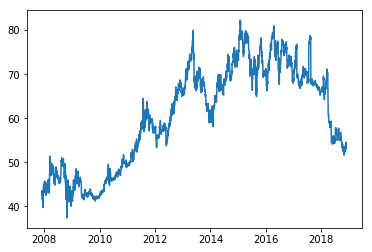

In [6]:
plt.plot(ts)
plt.show()

In [7]:
# Stationarity of the ARIMA Model
def test_stationarity(timeseries): 
    # rolling stats
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    #plot 
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # dickey fuller
    print("Results of Dickey Fuller Test: ")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

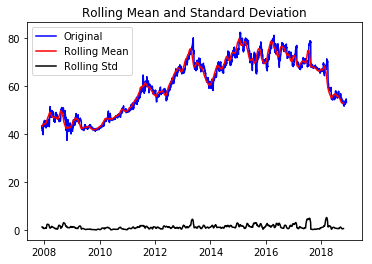

Results of Dickey Fuller Test: 
Test Statistic                   -1.467789
p-value                           0.549381
#Lags Used                        0.000000
Number of Observations Used    2715.000000
Critical Value (1%)              -3.432761
Critical Value (5%)              -2.862605
Critical Value (10%)             -2.567337
dtype: float64


In [8]:
test_stationarity(ts)

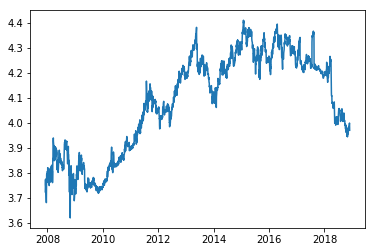

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

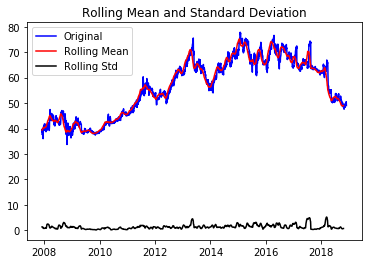

Results of Dickey Fuller Test: 
Test Statistic                   -1.470862
p-value                           0.547873
#Lags Used                        0.000000
Number of Observations Used    2715.000000
Critical Value (1%)              -3.432761
Critical Value (5%)              -2.862605
Critical Value (10%)             -2.567337
dtype: float64


In [11]:
ts_log_diff = ts - ts_log
test_stationarity(ts_log_diff)

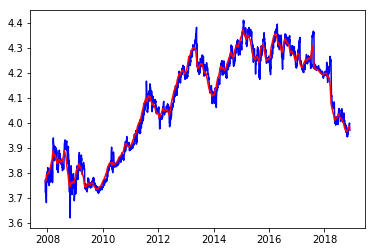

In [12]:
expweighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log, color = "blue")
plt.plot(expweighted_avg, color = "red")
plt.show()

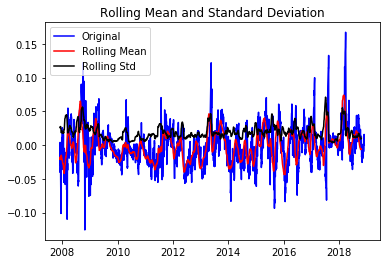

Results of Dickey Fuller Test: 
Test Statistic                -1.154214e+01
p-value                        3.613019e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.715000e+03
Critical Value (1%)           -3.432761e+00
Critical Value (5%)           -2.862605e+00
Critical Value (10%)          -2.567337e+00
dtype: float64


In [13]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

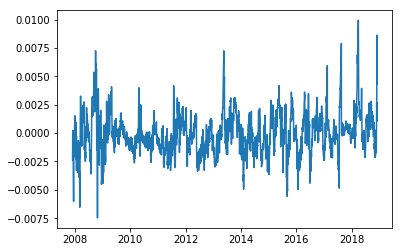

In [14]:
ts_log_ewma_diff = expweighted_avg - expweighted_avg.shift()
plt.plot(ts_log_ewma_diff)
plt.show()

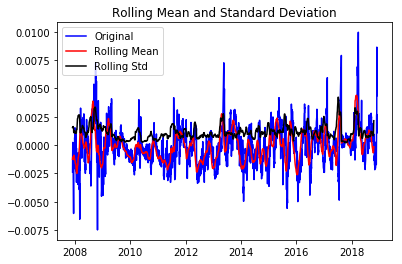

Results of Dickey Fuller Test: 
Test Statistic                -1.198365e+01
p-value                        3.655475e-22
#Lags Used                     0.000000e+00
Number of Observations Used    2.714000e+03
Critical Value (1%)           -3.432762e+00
Critical Value (5%)           -2.862606e+00
Critical Value (10%)          -2.567337e+00
dtype: float64


In [15]:
ts_log_ewma_diff.dropna(inplace = True)
test_stationarity(ts_log_ewma_diff)

In [16]:
#Parameters Optimization
# Plot ACF and PACF 

lag_acf = acf(ts_log_ewma_diff, nlags = 20)
lag_pacf = pacf (ts_log_ewma_diff, nlags = 20, method = 'ols')

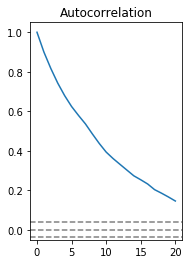

In [17]:
# ACF
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation')
plt.show()

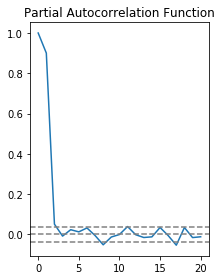

In [18]:
# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


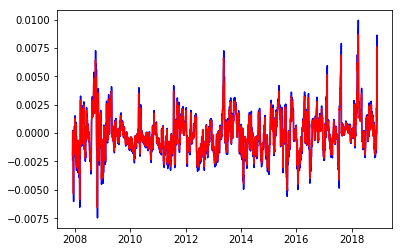

In [19]:
# ARIMA modeling

model = ARIMA(expweighted_avg, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_ewma_diff, color = 'blue')
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.show()

In [20]:
sum((results_ARIMA.fittedvalues-ts_log_ewma_diff)**2)

0.0016223386055595757

In [21]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2018-11-29   -0.000067
2018-11-28    0.003918
2018-11-27    0.007607
2018-11-26    0.001382
2018-11-23    0.002211
dtype: float64

In [23]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2018-11-29   -0.000067
2018-11-28    0.003851
2018-11-27    0.011458
2018-11-26    0.012840
2018-11-23    0.015051
dtype: float64

In [24]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2007-12-03    3.769039
2007-12-04    3.771015
2007-12-05    3.771767
2007-12-06    3.771585
2007-12-07    3.772566
dtype: float64

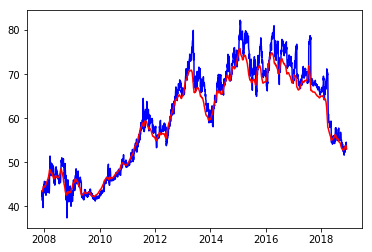

In [25]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, color = "blue")
plt.plot(predictions_ARIMA, color = "red")
plt.show()